# We want to use the TAXIFARES dataset to predict the fare amount

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('../Data/NYCTaxiFares.csv')

In [4]:
# Check the available features

df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1


In [5]:
# Check the target variable general distribution

df['fare_amount'].describe()

count    120000.000000
mean         10.040326
std           7.500134
min           2.500000
25%           5.700000
50%           7.700000
75%          11.300000
max          49.900000
Name: fare_amount, dtype: float64

## Feature Engineering

In [7]:
# The following fucntion will be used to calculate the distance between two locations on the surface of the Earth.

def haversine_distance(df, lat1, long1, lat2, long2):
    """
    Calculates the haversine distance between 2 sets of GPS coordinates in df
    """
    r = 6371  # average radius of Earth in kilometers
       
    phi1 = np.radians(df[lat1])
    phi2 = np.radians(df[lat2])
    
    delta_phi = np.radians(df[lat2]-df[lat1])
    delta_lambda = np.radians(df[long2]-df[long1])
     
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c) # in kilometers

    return d

In [8]:
# Check the column names of dataframe

df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

In [9]:
# Use the function to calculate the distance and add these result to a new column 'dist_km'

df['dist_km'] = haversine_distance(df, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

In [10]:
# Check the dataframe again to see the new feature

df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km
0,2010-04-19 08:17:56 UTC,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312
1,2010-04-17 15:43:53 UTC,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307
2,2010-04-17 11:23:26 UTC,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763
3,2010-04-11 21:25:03 UTC,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129
4,2010-04-17 02:19:01 UTC,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321


In [11]:
# Check the datatype of each feature

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   pickup_datetime    120000 non-null  object 
 1   fare_amount        120000 non-null  float64
 2   fare_class         120000 non-null  int64  
 3   pickup_longitude   120000 non-null  float64
 4   pickup_latitude    120000 non-null  float64
 5   dropoff_longitude  120000 non-null  float64
 6   dropoff_latitude   120000 non-null  float64
 7   passenger_count    120000 non-null  int64  
 8   dist_km            120000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 8.2+ MB


In [12]:
# Since the Dtype of pickup datetime is object, it should be transformed into datetime format for more time related features extraction.

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   pickup_datetime    120000 non-null  datetime64[ns, UTC]
 1   fare_amount        120000 non-null  float64            
 2   fare_class         120000 non-null  int64              
 3   pickup_longitude   120000 non-null  float64            
 4   pickup_latitude    120000 non-null  float64            
 5   dropoff_longitude  120000 non-null  float64            
 6   dropoff_latitude   120000 non-null  float64            
 7   passenger_count    120000 non-null  int64              
 8   dist_km            120000 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(2)
memory usage: 8.2 MB


In [14]:
my_time = df['pickup_datetime'][0]

In [15]:
my_time.hour

8

In [16]:
# Since the data was collected from NY, we need to change the time by 4 hours difference.

df['EDTdate'] = df['pickup_datetime'] - pd.Timedelta(hours=4)

In [17]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00


In [18]:
# Extract hour form datetime

df['Hour'] = df['EDTdate'].dt.hour

In [19]:
# The time in each day is splitted into three duration: moring, afternoon and evening(including night)

df['AMorPMorEVEN'] = df['Hour'].apply(lambda x: 'am' if x < 12 else 'pm' if x < 18 else 'even')

In [20]:
df.head()

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPMorEVEN
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,even


In [21]:
# The weekday was extracted.

df['Weekday'] = df['EDTdate'].dt.dayofweek

In [22]:
df

,pickup_datetime,fare_amount,fare_class,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,dist_km,EDTdate,Hour,AMorPMorEVEN,Weekday
0,2010-04-19 08:17:56+00:00,6.5,0,-73.992365,40.730521,-73.975499,40.744746,1,2.126312,2010-04-19 04:17:56+00:00,4,am,0
1,2010-04-17 15:43:53+00:00,6.9,0,-73.990078,40.740558,-73.974232,40.744114,1,1.392307,2010-04-17 11:43:53+00:00,11,am,5
2,2010-04-17 11:23:26+00:00,10.1,1,-73.994149,40.751118,-73.960064,40.766235,2,3.326763,2010-04-17 07:23:26+00:00,7,am,5
3,2010-04-11 21:25:03+00:00,8.9,0,-73.990485,40.756422,-73.971205,40.748192,1,1.864129,2010-04-11 17:25:03+00:00,17,pm,6
4,2010-04-17 02:19:01+00:00,19.7,1,-73.990976,40.734202,-73.905956,40.743115,1,7.231321,2010-04-16 22:19:01+00:00,22,even,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,2010-04-18 14:33:03+00:00,15.3,1,-73.955857,40.784590,-73.981941,40.736789,1,5.751348,2010-04-18 10:33:03+00:00,10,am,6
119996,2010-04-23 10:27:48+00:00,15.3,1,-73.996329,40.772727,-74.049890,40.740413,1,5.767444,2010-04-23 06:27:48+00:00,6,am,4
119997,2010-04-18 18:50:40+00:00,12.5,1,-73.988574,40.749772,-74.011541,40.707799,3,5.052523,2010-04-18 14:50:40+00:00,14,pm,6
119998,2010-04-13 08:14:44+00:00,4.9,0,-74.004449,40.724529,-73.992697,40.730765,1,1.208923,2010-04-13 04:14:44+00:00,4,am,1


## Feature embedding

In [24]:
df.columns

Index(['pickup_datetime', 'fare_amount', 'fare_class', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km', 'EDTdate', 'Hour', 'AMorPMorEVEN',
       'Weekday'],
      dtype='object')

In [25]:
# Useful features were splitted into categorical features and continus features.

cat_cols = ['Hour', 'AMorPMorEVEN', 'Weekday']
cont_cols = ['pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'dist_km']

In [26]:
y_col = ['fare_amount']

In [27]:
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
EDTdate              datetime64[ns, UTC]
Hour                               int32
AMorPMorEVEN                      object
Weekday                            int32
dtype: object

In [28]:
# categorical features were really transformed into category type.

for cat in cat_cols:
    df[cat] = df[cat].astype('category')

In [29]:
df.dtypes

pickup_datetime      datetime64[ns, UTC]
fare_amount                      float64
fare_class                         int64
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
dist_km                          float64
EDTdate              datetime64[ns, UTC]
Hour                            category
AMorPMorEVEN                    category
Weekday                         category
dtype: object

In [30]:
df['Hour'].head()

0     4
1    11
2     7
3    17
4    22
Name: Hour, dtype: category
Categories (24, int32): [0, 1, 2, 3, ..., 20, 21, 22, 23]

In [31]:
df['AMorPMorEVEN'].head()

0      am
1      am
2      am
3      pm
4    even
Name: AMorPMorEVEN, dtype: category
Categories (3, object): ['am', 'even', 'pm']

In [32]:
# Check unique category values in feature 'AMorPMorEVEN'

df['AMorPMorEVEN'].cat.categories

Index(['am', 'even', 'pm'], dtype='object')

In [33]:
df['AMorPMorEVEN'].cat.codes

0         0
1         0
2         0
3         2
4         1
         ..
119995    0
119996    0
119997    2
119998    0
119999    2
Length: 120000, dtype: int8

In [34]:
# Check unique category values in feature 'Weekday'

df['Weekday'].cat.categories

Index([0, 1, 2, 3, 4, 5, 6], dtype='int32')

In [35]:
df['Weekday'].cat.codes.values

array([0, 5, 5, ..., 6, 1, 5], dtype=int8)

In [36]:
# Deep learning needs tensor. numpy array is needed first.

hr = df['Hour'].cat.codes.values
ampmeven = df['AMorPMorEVEN'].cat.codes.values
wkdy = df['Weekday'].cat.codes.values

In [37]:
hr

array([ 4, 11,  7, ..., 14,  4, 12], dtype=int8)

In [38]:
# concatenate all these three categorical features together in the form of numpy array.

cats = np.stack([hr, ampmeven, wkdy], axis=1)

In [39]:
cats

array([[ 4,  0,  0],
       [11,  0,  5],
       [ 7,  0,  5],
       ...,
       [14,  2,  6],
       [ 4,  0,  1],
       [12,  2,  5]], dtype=int8)

In [40]:
# Transform the cats into tensors

cats = torch.tensor(cats, dtype=torch.int64)

In [41]:
cats

tensor([[ 4,  0,  0],
        [11,  0,  5],
        [ 7,  0,  5],
        ...,
        [14,  2,  6],
        [ 4,  0,  1],
        [12,  2,  5]])

In [42]:
# Combine all continuous values together and get the numpy array form.

conts = np.stack([df[cont].values for cont in cont_cols],axis=1)

In [43]:
# Transform these continuous values into tensors

conts = torch.tensor(conts, dtype=torch.float)

In [44]:
conts

tensor([[-73.9924,  40.7305, -73.9755,  40.7447,   1.0000,   2.1263],
        [-73.9901,  40.7406, -73.9742,  40.7441,   1.0000,   1.3923],
        [-73.9941,  40.7511, -73.9601,  40.7662,   2.0000,   3.3268],
        ...,
        [-73.9886,  40.7498, -74.0115,  40.7078,   3.0000,   5.0525],
        [-74.0044,  40.7245, -73.9927,  40.7308,   1.0000,   1.2089],
        [-73.9554,  40.7719, -73.9676,  40.7630,   3.0000,   1.4274]])

In [45]:
# Transform target variable into tensors.

y = torch.tensor(df[y_col].values, dtype=torch.float)

### Check data shape before further steps

In [47]:
cats.shape

torch.Size([120000, 3])

In [48]:
conts.shape

torch.Size([120000, 6])

In [49]:
y.shape

torch.Size([120000, 1])

In [50]:
# Check total dimensions of each cat

cat_szs = [len(df[col].cat.categories) for col in cat_cols]

In [51]:
cat_szs

[24, 3, 7]

In [52]:
# emb_szs should be a list of tuples including size of each cat and the embedding size
# embedding size is the smaller values of 50 and (size+1)//2

emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]

In [53]:
emb_szs

[(24, 12), (3, 2), (7, 4)]

### Here it shows a example of the first two values in cats. 4 and 11 is the values of hours, 0 and 0 means morning? 0 and 5 means Monday and Saturday?

In [55]:
catz = cats[:2]

In [56]:
catz

tensor([[ 4,  0,  0],
        [11,  0,  5]])

In [57]:
# We get emb_szs of these small tensors.

selfembeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_szs])

In [58]:
selfembeds

ModuleList(
  (0): Embedding(24, 12)
  (1): Embedding(3, 2)
  (2): Embedding(7, 4)
)

In [59]:
# Forward method (cats) to get embeddings of these 6 numbers.
embeddingz = []

for i,e in enumerate(selfembeds):
    print(f'i is: {i} and e is: {e}')
    print(catz[:, i])
    embeddingz.append(e(catz[:, i]))

i is: 0 and e is: Embedding(24, 12)
tensor([ 4, 11])
i is: 1 and e is: Embedding(3, 2)
tensor([0, 0])
i is: 2 and e is: Embedding(7, 4)
tensor([0, 5])


In [60]:
# each value in Hour col, it has 12 embedding values.
# each value in ampmeven col, it has 2 embedding values.
# each value in wkdy col, it has 2 embedding values.
embeddingz

[tensor([[-0.8079,  1.4831, -0.3515,  0.5896, -0.2595, -1.0278, -0.6118,  1.6086,
          -0.8685, -1.1896,  0.3558, -0.6963],
         [-0.0462, -0.0711,  1.8910, -1.7114, -0.0951,  0.5796,  0.8313,  0.8357,
          -1.8594,  0.8251,  0.7366,  1.0889]], grad_fn=<EmbeddingBackward0>),
 tensor([[1.2094, 0.8283],
         [1.2094, 0.8283]], grad_fn=<EmbeddingBackward0>),
 tensor([[ 0.2409,  0.9758, -1.7199, -1.1718],
         [ 0.6208,  0.8109,  0.8478, -0.8842]], grad_fn=<EmbeddingBackward0>)]

In [61]:
# concatenate them into one tensor
z = torch.cat(embeddingz, 1)

In [62]:
z

tensor([[-0.8079,  1.4831, -0.3515,  0.5896, -0.2595, -1.0278, -0.6118,  1.6086,
         -0.8685, -1.1896,  0.3558, -0.6963,  1.2094,  0.8283,  0.2409,  0.9758,
         -1.7199, -1.1718],
        [-0.0462, -0.0711,  1.8910, -1.7114, -0.0951,  0.5796,  0.8313,  0.8357,
         -1.8594,  0.8251,  0.7366,  1.0889,  1.2094,  0.8283,  0.6208,  0.8109,
          0.8478, -0.8842]], grad_fn=<CatBackward0>)

In [63]:
# Here it shows how Dropout works. 0.4 means 40% of embeddings will be changed to 0

selfembdrop = nn.Dropout(0.4)

In [64]:
z = selfembdrop(z)

In [65]:
z

tensor([[-1.3465,  2.4718, -0.0000,  0.9826, -0.4324, -0.0000, -0.0000,  2.6811,
         -1.4475, -1.9826,  0.0000, -0.0000,  2.0157,  1.3805,  0.4015,  1.6264,
         -2.8665, -0.0000],
        [-0.0770, -0.1185,  3.1516, -0.0000, -0.1584,  0.0000,  0.0000,  0.0000,
         -3.0991,  1.3752,  0.0000,  1.8148,  2.0157,  1.3805,  1.0347,  0.0000,
          0.0000, -1.4736]], grad_fn=<MulBackward0>)

## Start modeling

In [67]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):

        super().__init__()
        
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)

        layerlist = []
        n_emb = sum([nf for ni, nf in emb_szs])
        n_in = n_emb + n_cont

        for i in layers:
            layerlist.append(nn.Linear(n_in, i))
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i

        layerlist.append(nn.Linear(layers[-1], out_sz))

        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []

        for i, e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))

        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)

        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x
        

In [68]:
# Define attributes in the model

torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200, 100], p=0.4)

In [69]:
model.parameters()

<generator object Module.parameters at 0x0000020C0A91DD20>

In [70]:
# Check parameters in the model

model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(24, 12)
    (1): Embedding(3, 2)
    (2): Embedding(7, 4)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=24, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

In [71]:
# Set how to calculate loss and set up the gradient descent using Adam

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [72]:
# Total batch size is 60000. test size is 20% percent, the rest is training set

batch_size = 60000
test_size = int(batch_size*0.2)

In [73]:
# Define training set and testing set for cat and continuous features.
# The first 48000 is training set. The last 12000 is testing set.

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]

In [74]:
y_train = y[:batch_size-test_size]
y_test = y[batch_size-test_size:batch_size]

In [75]:
len(cat_train)

48000

In [76]:
len(con_train)

48000

In [77]:
len(cat_test)

12000

## Model training starts here

In [79]:
import time

start_time = time.time()

epochs = 300

losses = []

for i in range(epochs):
    i += 1

    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(criterion(y_pred, y_train))
    losses.append(loss)

    if i%10 == 1:
        print(f'Epoch: {i} Loss is {loss}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

duration = time.time() - start_time
print(f'Train took {duration/60} min')

Epoch: 1 Loss is 12.495585441589355
Epoch: 11 Loss is 11.521201133728027
Epoch: 21 Loss is 10.94216251373291
Epoch: 31 Loss is 10.581241607666016
Epoch: 41 Loss is 10.318862915039062
Epoch: 51 Loss is 10.107930183410645
Epoch: 61 Loss is 9.91942310333252
Epoch: 71 Loss is 9.744397163391113
Epoch: 81 Loss is 9.566658973693848
Epoch: 91 Loss is 9.337730407714844
Epoch: 101 Loss is 9.10572338104248
Epoch: 111 Loss is 8.823603630065918
Epoch: 121 Loss is 8.518335342407227
Epoch: 131 Loss is 8.159951210021973
Epoch: 141 Loss is 7.798380374908447
Epoch: 151 Loss is 7.346869468688965
Epoch: 161 Loss is 6.9004034996032715
Epoch: 171 Loss is 6.426007270812988
Epoch: 181 Loss is 5.971811294555664
Epoch: 191 Loss is 5.467038154602051
Epoch: 201 Loss is 5.011419773101807
Epoch: 211 Loss is 4.630671501159668
Epoch: 221 Loss is 4.294363975524902
Epoch: 231 Loss is 4.057375907897949
Epoch: 241 Loss is 3.951070785522461
Epoch: 251 Loss is 3.8542046546936035
Epoch: 261 Loss is 3.788541316986084
Epoch: 

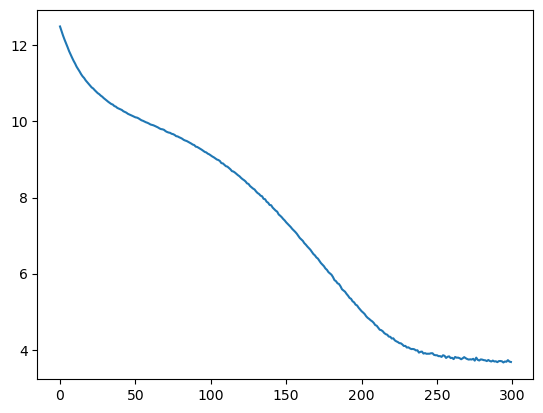

In [80]:
plt.plot(range(epochs), [loss.item() for loss in losses])

## No need to backpropagation, so here use torch.no_grad. Only for validate test set

In [82]:
with torch.no_grad():

    y_val = model(cat_test, con_test)

    loss = torch.sqrt(criterion(y_val, y_test))

In [83]:
loss

tensor(3.5983)

In [84]:
# Show the predicted values of test dataset

for i in range(10):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i},) Predicted: {y_val[i].item():8.2f} True: {y_test[i].item():8.2f} Diff: {diff:8.2f}')

0,) Predicted:     3.67 True:     2.90 Diff:     0.77
1,) Predicted:    18.75 True:     5.70 Diff:    13.05
2,) Predicted:     8.48 True:     7.70 Diff:     0.78
3,) Predicted:    13.99 True:    12.50 Diff:     1.49
4,) Predicted:     3.59 True:     4.10 Diff:     0.51
5,) Predicted:     5.89 True:     5.30 Diff:     0.59
6,) Predicted:     1.80 True:     3.70 Diff:     1.90
7,) Predicted:    14.47 True:    14.50 Diff:     0.03
8,) Predicted:     5.93 True:     5.70 Diff:     0.23
9,) Predicted:     8.57 True:    10.10 Diff:     1.53


In [85]:
torch.save(model.state_dict(), 'TaxiModel_09292024.pt')